In [83]:
%pylab inline
from statistics import mode
import yaml
import numpy as np

def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def parse_yaml_output(fname, output_keys = ['blocks', 'devices', 'triggers']):
    """
    Parse output file (yaml formatted) from spft-java
    Leave output_keys as default unless you really know what you are doing!
    """
    #TODO: identify if some keys are missing - likely not necessary given construction of yaml output

    #these are the keys for where the output data is stored
    # all timeseries data stored as 'times' and 'values'
    ## blocks = data from what was presented in this session, including metadata, presentation heights, and timestamps
    ## devices = raw device data and timestamps
    ## triggers = time and values of triggers
    yaml_data = load_yaml(fname)
    all_keys = yaml_data.keys()
    data = {}
    for key in all_keys:
        if key not in output_keys:
            data[key] = yaml_data[key]
    ## now we can do something with the input data as necessary
    ## TODO: PROCESSING!
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

def lag_calc(yy,yy_shifted):
    """
    Calculate lag, in discrete samples with cross-correlation. I.e., max resolution is one sample (1/freq)
    """
    #easy way, with max res of 1 unit of time
    #returns positive value for lag (i.e., yy_shifted occurs after yy in time)
    from scipy import signal
    
    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag*-1

def lag_calc_ms(for_time,ref_vals_interp,for_vals,initial_guess=0):
    """
    Based on least squares version, but turns out to be less accurate in some/many cases because extra data interpolated after/before
    there is real data interferes with the estimate
    """
    from scipy.interpolate import interp1d
    from scipy.optimize import leastsq
    # # compute temporal lag
    def err_func(p): #we fill data at the ends with the last value recorded for that trial (and first with first)
        # return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]
        return interp1d(for_time,ref_vals_interp,kind='cubic',bounds_error=False,fill_value=(for_vals[0],for_vals[-1]))(for_time[1:-1]+p[0]) - for_vals[1:-1]
        # return interp1d(for_time,ref_vals_interp,kind='cubic',bounds_error=False,fill_value=np.mean(for_vals))(for_time[1:-1]+p[0]) - for_vals[1:-1]
    p0 = [initial_guess,] # Inital guess: 0 = no shift
    found_shift = leastsq(err_func,p0)[0][0]
    return found_shift*-1 #positive values are greater lag (i.e., response after reference)

def get_trial_type_from_name(trial_name, trial_type_keys):
    """
    Helper function to return the trial type from given trial_name and set of all possible types
    """
    trial_key_idx = []    
    for idx,trial_name_key in enumerate(trial_type_keys):
        if trial_name_key in trial_name:
            trial_key_idx.append(idx)
    if len(trial_key_idx)>1:
        print('The trial names set in your config file were not uniquely identifiable')
        print('Exiting --------------------------------------------------------------')
        return 'XXX_ERROR_XXX'
    else:
        return trial_type_keys[trial_key_idx[0]]

def score_spft_data(data,device_idx=0,description = "e.g., right hand performance", 
                    reference_designation='leftReference', trial_type_keys = ['LRN','SMP','RST'],
                    exclude_meta_keys = ['blocks','devices'], save_trial_data=True):
    """
    Compute lag and rmse/sse for SPFT data per trial for all trial_type_keys. Output dictionary contains metadata
    from input, blocked data by trial_type ['block_?'] and concatenated data by trial_type ['all'].
    Triggers not yet handled in the processing (TODO: output summary scored data between each set of triggers)
    exclude_meta_keys:      dictionary keys to exclude from stored metadata, by default ['blocks','devices'],
                            which are the presentation data and the response data respectively 
    """
    MVC = data['maximumLeftVoluntaryContraction']
    blocks = data['blocks']
    for_resp = data['devices'][device_idx]
    #all times and values from the device over the course of the experiment, stored as single vectors
    for_time_all = np.array(for_resp['times'])
    for_vals_all = compute_normalized_force_response(np.array(for_resp['values']),MVC) #convert to normalized value for comparison

    all_lag_xcorr_ms = []
    all_lag_lstsq_ms = []
    all_raw_rmse = []
    all_raw_sse = []
    all_rmse = []
    all_sse = []

    res = {} #results dictionary
    for key in data.keys():
        if not (key in exclude_meta_keys):
            res[key] = data[key]
    res['reference_designation'] = reference_designation #L or R reference bar
    res['description'] = description
    res['all'] = {}
    if save_trial_data:
        res['trial_data'] = {}
        res['trial_data']['ref_interp'] = []
        res['trial_data']['for_interp'] = []
        res['trial_data']['common_time'] = []
        res['trial_data']['ref_raw'] = []
        res['trial_data']['for_raw'] = []
        res['trial_data']['ref_time_raw'] = []
        res['trial_data']['for_time_raw'] = []
        res['trial_data']['ref_interp_snipped'] = []
        res['trial_data']['for_interp_snipped'] = []
               

    for trial_type in trial_type_keys:
        res['all'][trial_type] = {}
        res['all'][trial_type]['lag_xcorr_ms'] = []
        res['all'][trial_type]['lag_lstsq_ms'] = []
        res['all'][trial_type]['raw_rmse'] = []
        res['all'][trial_type]['raw_sse'] = []
        res['all'][trial_type]['rmse'] = []
        res['all'][trial_type]['sse'] = []

    for block_idx in np.arange(len(blocks)):
        res[f'block_{block_idx}'] = {}
        for trial_type in trial_type_keys:
            res[f'block_{block_idx}'][trial_type] = {}
            res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'] = []
            res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'] = []
            res[f'block_{block_idx}'][trial_type]['raw_rmse'] = []
            res[f'block_{block_idx}'][trial_type]['raw_sse'] = []
            res[f'block_{block_idx}'][trial_type]['rmse'] = []
            res[f'block_{block_idx}'][trial_type]['sse'] = []

        for trial_idx in np.arange(len(blocks[block_idx]['trials'])):
            trial_name = blocks[block_idx]['trials'][trial_idx]['trialName']
            trial_type = get_trial_type_from_name(trial_name,trial_type_keys)
            ref_time = np.array(blocks[block_idx]['trials'][trial_idx][reference_designation]['times'])
            ref_vals = np.array(blocks[block_idx]['trials'][trial_idx][reference_designation]['values'])

            start = ref_time[0]
            end = ref_time[-1]
            # print(end-start)

            # compute mask of data in for response vector associated with this specific trial, select time/vals
            for_trial_mask = (for_time_all-start >= 0) & (for_time_all-end<=0) 
            for_time = for_time_all[for_trial_mask]
            for_vals = for_vals_all[for_trial_mask]

            # bring ref vals into the same time space by interpolating, for direct comparison
            # then compute lag and other metrics, also shift by lag and compute metrics again
            # times are in ms, and we use the median time per interval for the conversion of lag (in timestep units) to ms
            # return for_time,ref_time,for_vals,ref_vals
            common_time = np.linspace(ref_time.min(),ref_time.max(),ref_time.shape[0]*2)
            ref_vals_interp = np.interp(common_time,ref_time,ref_vals)
            for_vals_interp = np.interp(common_time,for_time,for_vals)
            # ref_vals_interp = interp1d(ref_time,ref_vals,kind='cubic')(for_time) #does not seem to make a difference here
            trial_lag_xcorr = lag_calc(ref_vals_interp,for_vals_interp) #in samples
            time_per_interval = np.mean(np.diff(common_time)) #time, in ms
            time_std_per_interval = np.std(np.diff(common_time)) #time, in ms
            trial_lag_xcorr_ms = trial_lag_xcorr*time_per_interval
            common_time = common_time - common_time[0] #zero time so that our plots start at 0
            trial_lag_ms = lag_calc_ms(common_time,ref_vals_interp,for_vals_interp) #alternative way, not sure if this is correct in the end
            # print(trial_lag_ms)
            
            # raw RMSE and SSE
            trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals_interp)**2)) #root mean squared error
            trial_sse = ((ref_vals_interp-for_vals_interp)**2).sum()


            # we now take the aligned vectors, snip the parts that we do not have data for, and compare to compute our lag-aligned version
            if trial_lag_xcorr >0: #we have a lag (i.e., the force comes after the reference)
                snipped_for_vals = for_vals_interp[trial_lag_xcorr:]
                snipped_ref_vals = ref_vals_interp[0:trial_lag_xcorr*-1]
                # snipped_for_time = for_time[trial_lag_xcorr:]
            elif trial_lag_xcorr <0: #force preceded the reference
                snipped_for_vals = for_vals_interp[0:trial_lag_xcorr*-1]
                snipped_ref_vals = ref_vals_interp[trial_lag_xcorr:]
                # snipped_for_time = for_time[0:trial_lag_xcorr*-1]
            elif trial_lag_xcorr == 0:
                snipped_for_vals = for_vals_interp
                snipped_ref_vals = ref_vals_interp
                # snipped_for_time = for_time

            # proportion of elements used to compute RMSE and SSE
            # trial_prop_good_els = snipped_for_vals.shape[0] / ref_vals_interp.shape[0] 
            # lag-algined RMSE and SSE
            lag_aligned_trial_rmse = np.sqrt(np.mean((snipped_ref_vals-snipped_for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
            lag_aligned_trial_sse = ((snipped_ref_vals-snipped_for_vals)**2).sum()
            
            # print(f'Block {block_idx} - Trial {trial_idx}')
            # print(f'median interval time: {time_per_interval:.2f} ms')
            # print(f'std interval time   : {time_std_per_interval:.2f} ms')
            # print(f'lag (time steps)    : {trial_lag_xcorr}')
            # print(f'lag                 : {trial_lag_xcorr_ms:.2f} ms')
            # print(f'lag (lstsq)         : {trial_lag_ms:.2f}')
            # print(f'rmse                : {trial_rmse:.2f} ms')
            # print(f'sse                 : {trial_sse:.2f} ms')
            # print(f'lag-aligned rmse    : {lag_aligned_trial_rmse:.2f} ms')
            # print(f'lag-aligned sse     : {lag_aligned_trial_sse:.2f} ms')
            # print(f'prop good elelements: {trial_prop_good_els:.2f}')
            # print("")
            
            # print(np.corrcoef(snipped_for_vals,snipped_ref_vals)[0,1])
            # print(np.corrcoef(ref_vals_interp,np.interp(for_time+trial_lag_ms, for_time,for_vals))[0,1])
            
            if save_trial_data:
                res['trial_data']['ref_interp'].append(ref_vals_interp)
                res['trial_data']['for_interp'].append(for_vals_interp)
                res['trial_data']['common_time'].append(common_time)

                res['trial_data']['ref_raw'].append(ref_vals)
                res['trial_data']['for_raw'].append(for_vals)
                res['trial_data']['ref_time_raw'].append(ref_time)
                res['trial_data']['for_time_raw'].append(for_time)

                res['trial_data']['ref_interp_snipped'].append(snipped_ref_vals)
                res['trial_data']['for_interp_snipped'].append(snipped_for_vals)
                

            #block-wise data
            res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'].append(trial_lag_xcorr_ms)
            res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'].append(trial_lag_ms)
            res[f'block_{block_idx}'][trial_type]['raw_rmse'].append(trial_rmse)
            res[f'block_{block_idx}'][trial_type]['raw_sse'].append(trial_sse)
            res[f'block_{block_idx}'][trial_type]['rmse'].append(lag_aligned_trial_rmse)
            res[f'block_{block_idx}'][trial_type]['sse'].append(lag_aligned_trial_sse)
            
            #all data concatenated
            res['all'][trial_type]['lag_xcorr_ms'].append(trial_lag_xcorr_ms)
            res['all'][trial_type]['lag_lstsq_ms'].append(trial_lag_ms)
            res['all'][trial_type]['raw_rmse'].append(trial_rmse)
            res['all'][trial_type]['raw_sse'].append(trial_sse)
            res['all'][trial_type]['rmse'].append(lag_aligned_trial_rmse)
            res['all'][trial_type]['sse'].append(lag_aligned_trial_sse)
        
        #convert the current block results to numpy arrays
        res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'] = np.array(res[f'block_{block_idx}'][trial_type]['lag_xcorr_ms'])
        res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'] = np.array(res[f'block_{block_idx}'][trial_type]['lag_lstsq_ms'])
        res[f'block_{block_idx}'][trial_type]['raw_rmse'] = np.array(res[f'block_{block_idx}'][trial_type]['raw_rmse'])
        res[f'block_{block_idx}'][trial_type]['raw_sse'] = np.array(res[f'block_{block_idx}'][trial_type]['raw_sse'])
        res[f'block_{block_idx}'][trial_type]['rmse'] = np.array(res[f'block_{block_idx}'][trial_type]['rmse'])
        res[f'block_{block_idx}'][trial_type]['sse'] = np.array(res[f'block_{block_idx}'][trial_type]['sse'])
            
            # plt.figure()
            # plt.plot(for_time,ref_vals_interp,'k-',label='reference')
            # plt.plot(for_time,for_vals,'b-',alpha=0.5, label='force')
            # # plt.plot(snipped_for_time,snipped_ref_vals,'k-',label='reference')
            # plt.plot(snipped_for_time-trial_lag_xcorr_ms,snipped_for_vals,'r:',label='aligned force')
            # plt.plot(snipped_for_time-trial_lag_ms,snipped_for_vals,'g:',label='aligned force')
            
            # # plt.text(f'lag {trial_lag_xcorr_ms:.2f} ms')
            # plt.legend()
        #     print(np.corrcoef(snipped_for_vals, snipped_ref_vals)[0,1])
        #     print(trial_lag_xcorr)
        #     print(np.corrcoef(snipped_for_vals[first_match_idx:], snipped_ref_vals[first_match_idx:])[0,1])
        #     if trial_idx ==1:
        #         break

    #convert summary results in 'all' to numpy arrays
    res['all'][trial_type]['lag_xcorr_ms'] = np.array(res['all'][trial_type]['lag_xcorr_ms'])
    res['all'][trial_type]['lag_lstsq_ms'] = np.array(res['all'][trial_type]['lag_lstsq_ms'])
    res['all'][trial_type]['raw_rmse'] = np.array(res['all'][trial_type]['raw_rmse'])
    res['all'][trial_type]['raw_sse'] = np.array(res['all'][trial_type]['raw_sse'])
    res['all'][trial_type]['rmse'] = np.array(res['all'][trial_type]['rmse'])
    res['all'][trial_type]['sse'] = np.array(res['all'][trial_type]['sse'])
        
    return res

Populating the interactive namespace from numpy and matplotlib


In [47]:
from os.path import join
in_dir = './testing/2022_06_test_right_only'
subs = ['Derek','Isa','Jhelum_L','Kimia','Mika']
data = load_yaml(join(in_dir,f'LAB_{subs[0]}_Test_Right_Only_out-file.txt'))

# for idx,sub in enumerate(subs):
#     print(sub)
    # data = spft.load_yaml(join(in_dir,f'LAB_{sub}_Test_Right_Only_out-file.txt'))
    # LRN_lag = spft.score_spft_data(data)['all']['LRN']['lag_xcorr_ms']
    # if idx == 0:
    #     all_LRN_lag = np.zeros((len(subs),LRN_lag.shape[0]))
    # all_LRN_lag[idx,:] = LRN_lag

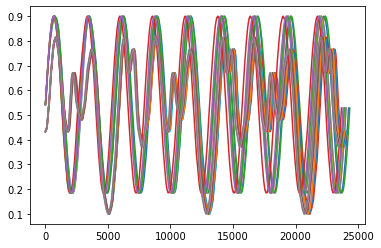

In [84]:
res=score_spft_data(data)

for idx in range(len(res['trial_data']['ref_interp'])):
    plt.plot(res['trial_data']['common_time'][idx],res['trial_data']['ref_interp'][idx])

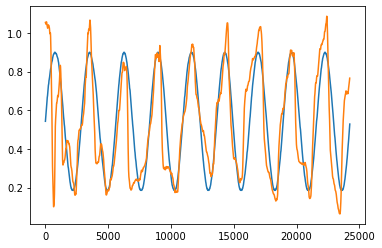

In [85]:
for idx in range(1):
    plt.plot(res['trial_data']['ref_time_raw'][idx]-res['trial_data']['ref_time_raw'][idx].min(),res['trial_data']['ref_raw'][idx])
for idx in range(1):
    plt.plot(res['trial_data']['for_time_raw'][idx]-res['trial_data']['for_time_raw'][idx].min(),res['trial_data']['for_raw'][idx])


In [86]:
print(res['trial_data']['ref_time_raw'][idx].shape)
print(res['trial_data']['for_time_raw'][idx].shape)

(1440,)
(2057,)


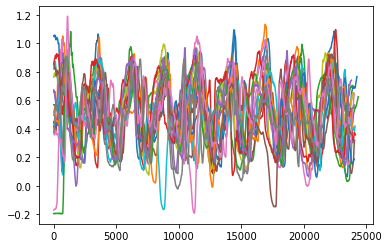

In [87]:
for idx in range(len(res['trial_data']['ref_interp'])):
    plt.plot(res['trial_data']['common_time'][idx],res['trial_data']['for_interp'][idx])

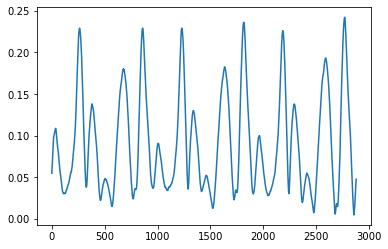

In [88]:
plt.plot(np.std(np.array(res['trial_data']['ref_interp']),axis=0))

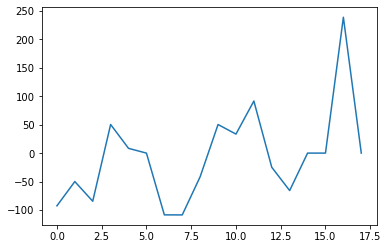

In [89]:
plt.plot(res['all']['LRN']['lag_xcorr_ms'])

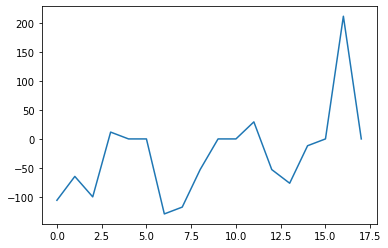

In [43]:
plt.plot(res['all']['LRN']['lag_xcorr_ms'])

(1972,)
(2880,)


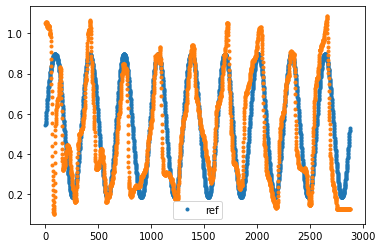

In [27]:
common_time = np.linspace(ref_time.min(),ref_time.max(),ref_time.shape[0]*2)
ref_vals_interp = np.interp(common_time,ref_time,ref_vals)
for_vals_interp = np.interp(common_time,for_time,for_vals)

plt.plot(ref_vals_interp,'.',label='ref')
plt.plot(for_vals_interp,'.')
plt.legend()
print(for_vals.shape)
print(for_vals_interp.shape)
#plt.plot(np.diff(for_time))

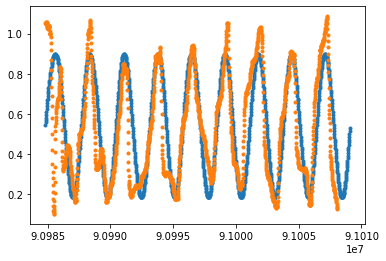

In [29]:
plt.plot(ref_time,ref_vals,'.')
plt.plot(for_time,for_vals,'.')

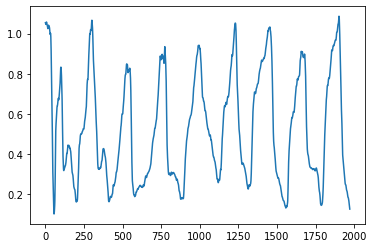

In [32]:
plt.plot(for_vals)

(1972,)
(3944,)


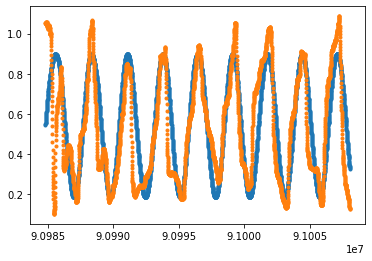

In [30]:
common_time = np.linspace(for_time.min(),for_time.max(),for_time.shape[0]*2)
ref_vals_interp = np.interp(common_time,ref_time,ref_vals)
for_vals_interp = np.interp(common_time,for_time,for_vals)

plt.plot(common_time,ref_vals_interp,'.')
plt.plot(common_time,for_vals_interp,'.')
print(for_vals.shape)
print(for_vals_interp.shape)
#plt.plot(np.diff(for_time))

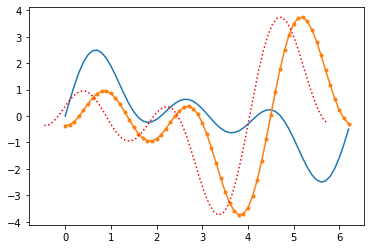

In [5]:
plt.plot(X,Y)
plt.plot(X,Y_shifted,'.-')
plt.plot(X+found_shift,Y_shifted,'r:',label='shifted')



In [6]:
np.sqrt(((Y-Y_shifted)**2).mean())

2.374271116111269

In [7]:
def lag_calc(yy,yy_shifted):
    from scipy import signal

    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag

TypeError: float() argument must be a string or a number, not 'function'

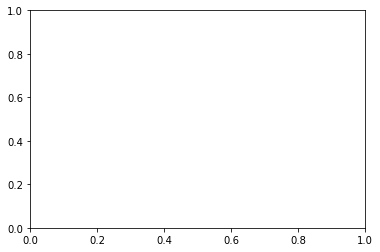

In [8]:
plt.plot(xcorr)

In [33]:

yy


array([ 0.        ,  0.00059994,  0.00119988, ..., -0.02091124,
       -0.02031138, -0.01971151])

In [5]:
import yaml
def load_yaml(fname):
    with open(fname, 'r') as file:
        data = yaml.safe_load(file)
    return data

def compute_normalized_force_response(device_force_values, MVC, forceRangeMin=0.05, forceRangeMax=0.30, clamp=None):
    """
    Convert from sensor values to heigt values that were used in the display for direct comparison to the target sequence. Works fine for any array.
    ((deviceForceValue / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)

    MVC:            maximumum voluntary contraction of this individual (in original device units)
    clamp:          list of min/max values to clamp any values that are above or below to, default = None (no clamping)
    """

    norm_resp = ((device_force_values / MVC) - forceRangeMin)/(forceRangeMax-forceRangeMin)
    if clamp is not None:
        norm_resp[norm_resp<clamp[0]] = clamp[0]
        norm_resp[norm_resp>clamp[1]] = clamp[1]
    return norm_resp

In [82]:
def lag_calc(yy,yy_shifted):
    #easy way, with max res of 1 unit of time
    from scipy import signal

    xcorr = signal.correlate(yy,yy_shifted,mode='full')
    lags = signal.correlation_lags(yy.size,yy_shifted.size,mode='full')
    lag = lags[np.argmax(xcorr)]
    return lag

In [40]:
data = load_yaml('./testing/TEST_out-file.yml')
blocks = data['blocks']
# input data 1st block 1st trial (left): blocks[0]['trials'][0]['leftReference']
#       times,values
#block start time @ startTimestamp, end @ endTimestamp

MVC = data['maximumLeftVoluntaryContraction']
ref_time = np.array(blocks[0]['trials'][0]['leftReference']['times'])
ref_vals = np.array(blocks[0]['trials'][0]['leftReference']['values'])

#all times from the device over the course of the experiment
for_resp = data['devices'][0]
for_time_all = np.array(for_resp['times'])
for_vals_all = compute_normalized_force_response(np.array(for_resp['values']),MVC)

#loop this to identify the start and end times of the trials
start = ref_time[0]
end = ref_time[-1]

for_trial_mask = (for_time_all-start >= 0) & (for_time_all-end<=0)
for_time = for_time_all[for_trial_mask]
for_vals = for_vals_all[for_trial_mask]

ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

#but first we should do the crosscorr
trial_rmse = np.sqrt(np.mean((ref_vals_interp-for_vals)**2)) #root mean squared error #TOOD: have someone confirm algo
trial_sse = ((ref_vals_interp-for_vals)**2).sum()


In [162]:
ref_vals_interp.shape
ref_time.shape

(1800,)

75.01078492992693
146


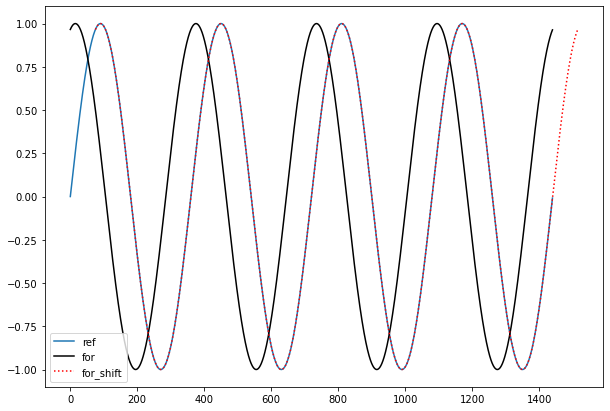

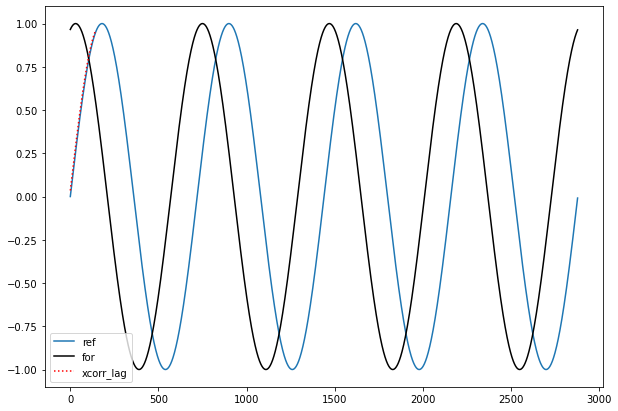

In [199]:
## testing this approach, WITHOUT interpolation of the signal (all timeseries are same length)
num_els = 500
offset = 75
for_time = np.arange(0,360*4,.5)
for_vals = np.sin((for_time* np.pi / 180)+(offset* np.pi / 180))
ref_time = for_time#[::2]
ref_vals = np.sin(ref_time* np.pi / 180)
ref_vals_interp = np.interp(for_time,ref_time,ref_vals) #linear (piece-wise) interpolation of presented target bar positions into the actual response, now we can subtract directly

# compute temporal lag
def err_func(p):
    # print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate")(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
lag_xcorr = lag_calc(ref_vals_interp,for_vals)
print(found_shift)
print(lag_xcorr)

# lstsq approach
plt.figure(figsize=(10,7))
# plt.plot(ref_time,ref_vals,'.',label='ref_orig')
plt.plot(for_time,ref_vals_interp,label='ref')
plt.plot(for_time,for_vals,'k-',label='for')
plt.plot(for_time+found_shift,for_vals,'r:',label='for_shift')
plt.legend()

plt.figure(figsize=(10,7)) #xcorr approach
plt.plot(ref_vals_interp,label='ref')
plt.plot(for_vals,'k-',label='for')
plt.plot(for_vals[lag_xcorr*-1:],'r:',label='xcorr_lag')
plt.legend()

0.0

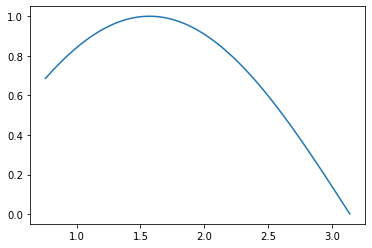

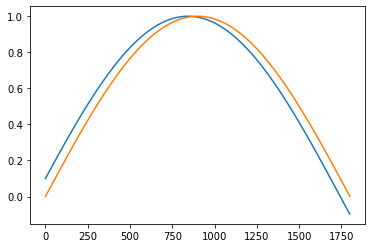

In [47]:
# compute temporal lag
def err_func(p):
    # print(p)
    return interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate",assume_sorted=True)(for_time[1:-1]+p[0]) - for_vals[1:-1]

p0 = [0,] # Inital guess of no shift
found_shift = leastsq(err_func,p0)[0][0]
print(found_shift)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [42]:
# plt.plot(interp1d(for_time,ref_vals_interp,kind='cubic',fill_value="extrapolate",assume_sorted=True)(for_time[1:-1]))
# plt.plot(for_time,for_vals)
ref_vals.shape

(121,)

In [56]:
plt.plot(interp1d(f_time,t_vals_interp,kind='cubic')(f_time[1:-1]+40) - f_vals[1:-1])

ValueError: A value in x_new is above the interpolation range.

221.48362918082947


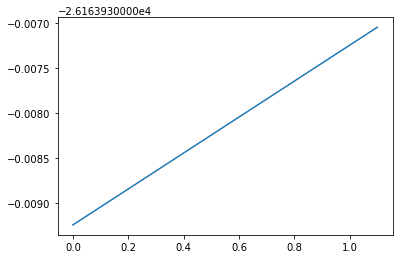

In [69]:
x_new = np.linspace(0,1.1,1000)
intfunc = interp1d(f_time,t_vals_interp,fill_value="extrapolate")

# plt.plot(f_time,t_vals_interp)
plt.plot(x_new,intfunc(x_new))

In [74]:
f_time.max()

13106296.01

In [78]:
crosscorr = np.correlate(f_vals,t_vals_interp,mode='full')
max_idx = np.where(crosscorr==np.max(crosscorr))[0]
if max_idx.shape[0] > 1:
    print("Oh no, you have more than one location with max lag!")
    return 9999


array([149])

array(0)

(array([403]),)

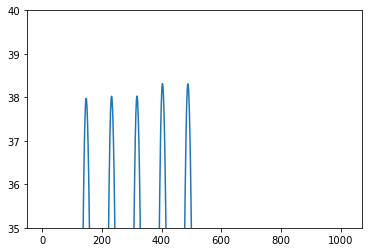

In [34]:
plt.plot(crosscorr),plt.ylim([35,40])
np.where(crosscorr==np.max(crosscorr))